# Discounts, Profit, and Causal Inference   
*An e-commerce case study in causal inference*

A/B tests, a.k.a. randomized controlled trials, are the gold standard for estimating causal effects of treatments (discounts, features, policies, ...) on business outcomes (profit, retention, engagement, ...). We randomly assign subjects (customers, users, sessions, ...) to treatment and control groups, ensuring that any observed differences can be attributed to the treatment rather than pre-existing characteristics. With proper randomization, causality follows directly from group comparison—no complex modeling required.

One common practical constraint is that experiments aren't always feasible. Policies get deployed for operational reasons, treatments are assigned based on business rules, and we're left with observational data where assignment wasn't random. In these cases, we need to first understand the __assignment mechanism__ —the rule determining who received treatment and why. Once we make this mechanism explicit, we can construct a quasi-experimental analysis: control for assignment drivers, ensure comparable groups, and separate selection effects from treatment effects. This approach recovers credible causal estimates from observational data.

A second business challenge is that average treatment effects only tell part of the story. A policy that's negative on average may still benefit specific customer segments. The question isn't just "does it work?" but "for whom does it work?" This is where __heterogeneous treatment effects__ meet __machine learning__ . Instead of one aggregate estimate, we model how effects vary with customer features (demographics, behavior, history, ...), predict individual-level uplift, and simulate targeted policies that capture benefits while avoiding losses. In this project, we'll build both a causal framework and a targeting strategy from observational data, creating a solution that can be refined when experimentation becomes possible.


## Business Context & Data Overview
### The Business Problem
An e-commerce company has been running a discount strategy for several quarters without clear evidence of its impact on profitability. They distribute discounts through an automated system based on customer characteristics and predictive analytics, but the exact mechanics and effectiveness remain unclear. The key question: are discounts actually driving incremental profit, or is the company simply giving money away?
To estimate the causal effect of discounts on profitability, an A/B test would be ideal. However, the company needs answers now based on existing data, where discounts were assigned through their production system—not through randomization. This observational data reflects how discounts are actually allocated in practice, based on some business logic that even management doesn't fully understand.

### The Dataset
The analysis uses historical transaction data (non_rand_discount.csv) containing customer purchase patterns and discount assignments. The dataset includes:

- __Customer spending history__: Monthly spend across 6 categories (baby, clothes, health, pet, groceries, electronics) for the past 6 months

- __Customer demographics__: Age, gender, state, and tenure (months since joining)

- __Model scores__: `sales_prediction` - an ML model's prediction of customer value, and `sales_prediction_bins` - discretized version used for discount assignment

- __Treatment and outcomes__: `discount` (amount given), `sales` (revenue generated), and `profit` (which is calculated as 5% of sales minus discount)

In [3]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import graphviz as gr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
dataset = pd.read_csv("data/non_rand_discount.csv", sep=";")
dataset["discount"] = pd.to_numeric(dataset["discount"].str.split(" ").str[-1])

In [5]:
def setup_dataframe_styling(header_color='#003f5c'):
    """Set DataFrame styling with custom header color and bold index"""
    def custom_repr_html(self):
        return self.style.set_table_styles([
            {'selector': 'thead th', 
             'props': [('background-color', header_color),
                       ('color', 'white'),
                       ('font-weight', 'bold'),
                       ('text-align', 'center'),
                       ('padding', '8px 12px')]},
            {'selector': 'tbody td', 
             'props': [('text-align', 'center'), ('padding', '8px 12px')]},
            {'selector': 'tbody tr:nth-child(even)', 
             'props': [('background-color', '#f8f9fa')]},
            # Bold index
            {'selector': 'tbody th', 
             'props': [('font-weight', 'bold'),
                       ('text-align', 'center'),
                       ('padding', '8px 12px')]}
        ])._repr_html_()
    
    pd.DataFrame._repr_html_ = custom_repr_html
    print(f"DataFrame styling activated with bold index and header color: {header_color}")

# Usage:
setup_dataframe_styling('#003f5c')  # Blog's dark blue with bold index

DataFrame styling activated with bold index and header color: #003f5c


In [6]:
dataset.head()

spend_1m_baby  spend_2m_baby  spend_3m_baby  spend_4m_baby  spend_5m_baby  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   spend_6m_baby  spend_1m_clothes  spend_2m_clothes  spend_3m_clothes  \
0            0.0                 0               0.0               0.0   
1            0.0                 0               0.0               0.0   
2            0.0                 0               0.0               0.0   
3            0.0                 0               0.0               0.0   
4            0.0                 0               0.0               0.0   

   spend_4m_clothes  ...  spend_6m_eletronic    sales  discount  profit  age  \
0               0.0  ...                 0.0  3368.64     125.0   40.06   40   
1               0.0  ...                 0.0  2133.10      75.0   29.52   36   
2               0.0  ...                 0.0  2001.62      50.0   48.08   34   
3               0.0  ...                 0.0  1461.96      10.0   61.64   31   
4               0.0  ...                 0.0  2743.72     100.0   34.44   32   

   gender  cust_state  tenure  sales_prediction_bins  sales_prediction  
0     1.0          MA       6                      8       1351.024765  
1     0.0          MG      10                      4       1035.580387  
2     0.0          RJ       7                      3        992.401825  
3     0.0          BA       7                      1        919.720735  
4     1.0          PB       6                      6       1176.485681  

[5 rows x 45 columns]

The profit of this e-commerce is calculated by:
 
$
Profit_i = Sales_i * 5\% - Discount_i
$

Let's examine how discounts correlate with business outcomes:

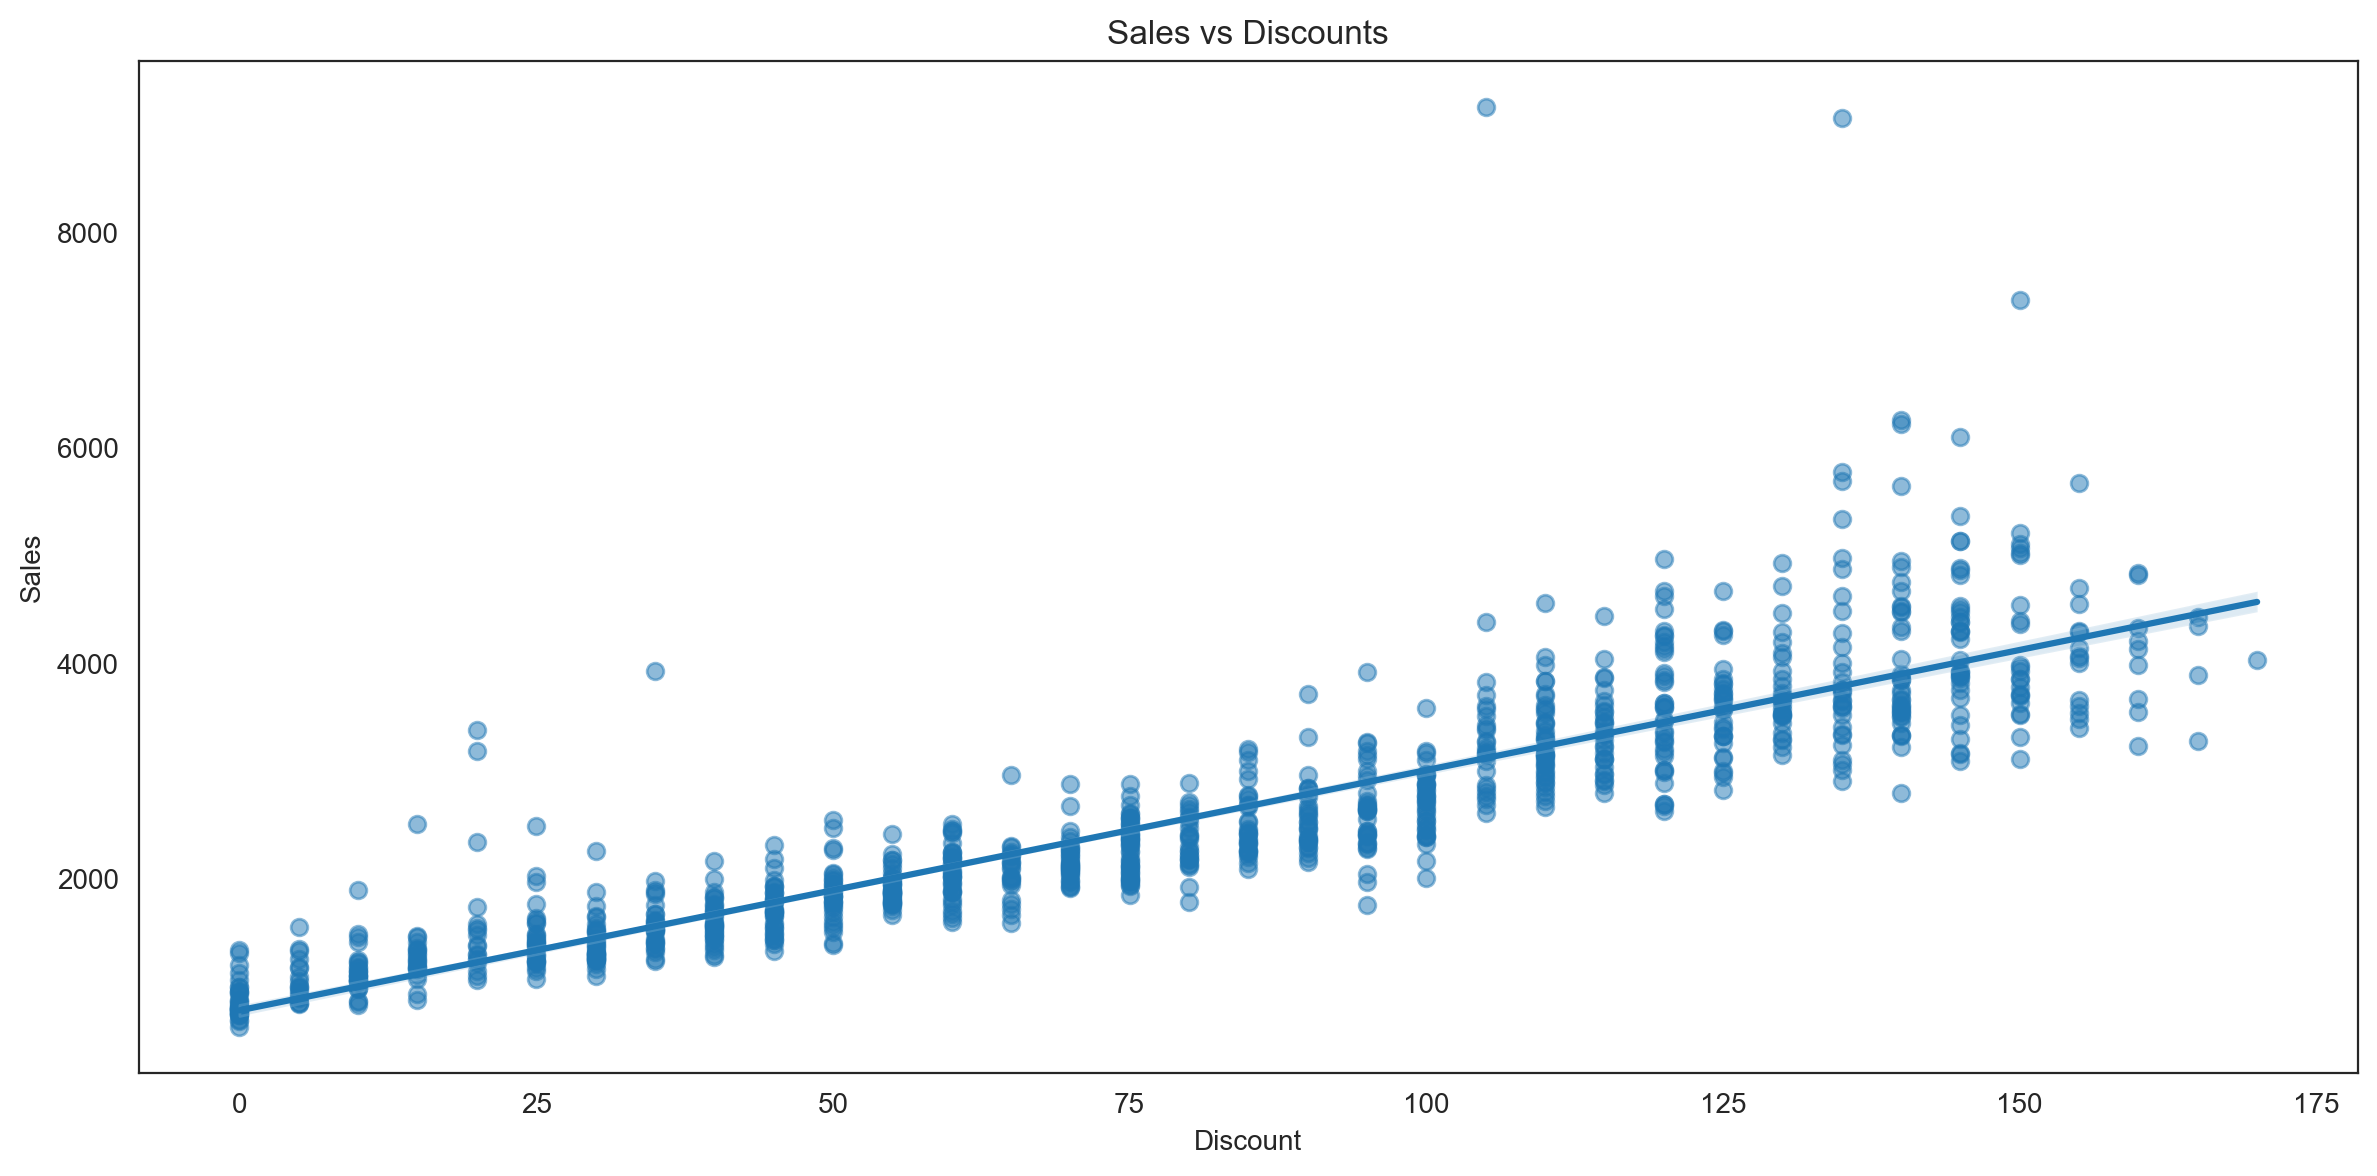

In [60]:
plt.figure(figsize=(12, 6))
sns.regplot(data = dataset.sample(1000), x="discount", y="sales", scatter_kws={"alpha":0.5})
plt.title('Sales vs Discounts')
plt.xlabel('Discount')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()




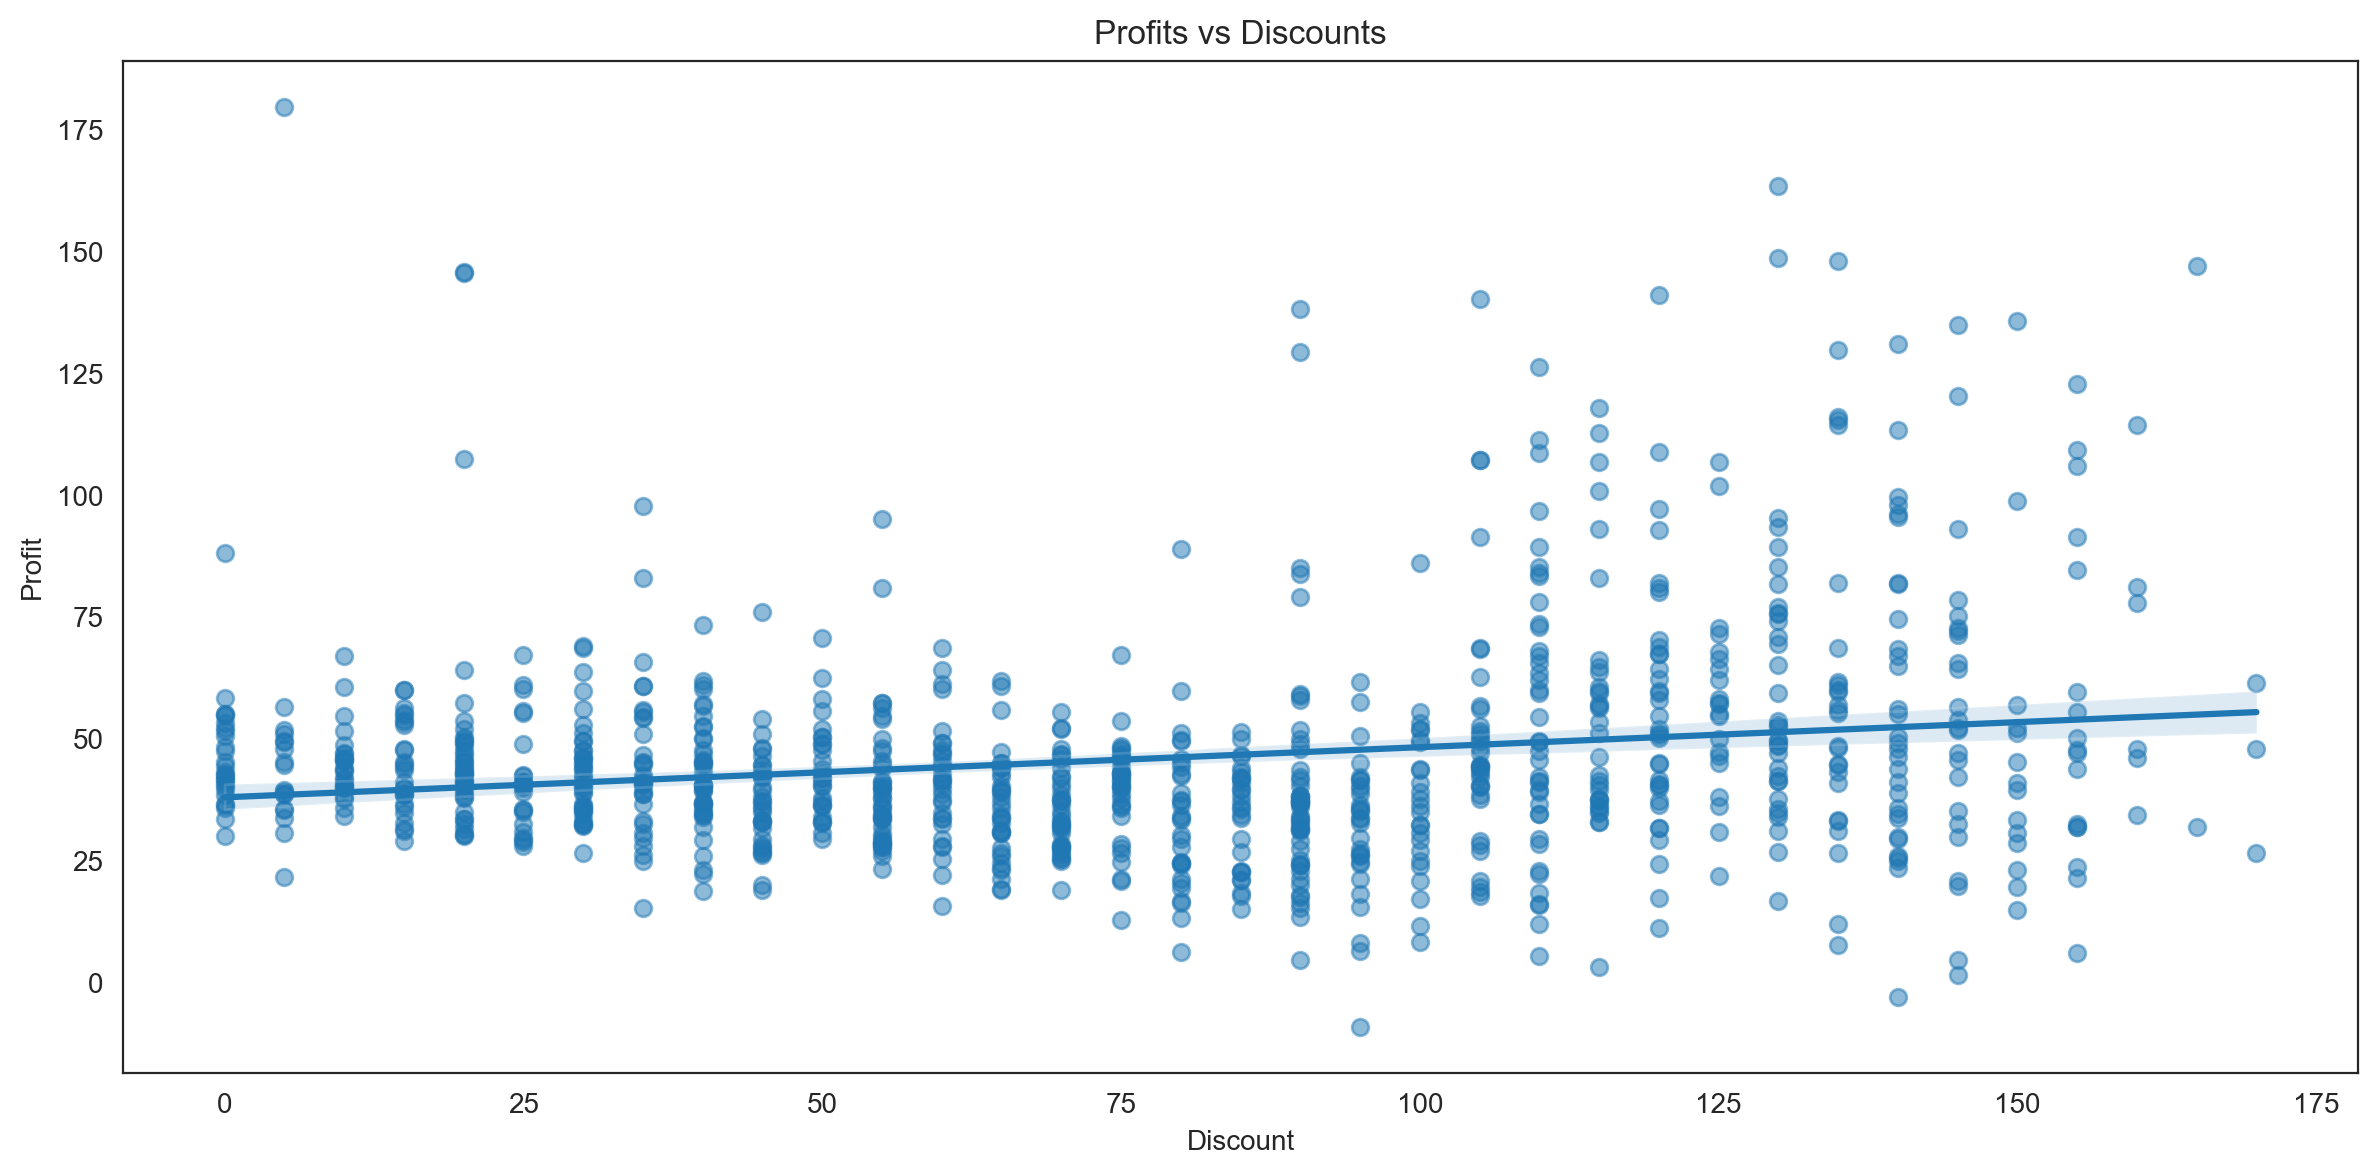

In [68]:
plt.figure(figsize=(12, 6))
sns.regplot(data = dataset.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.5})
plt.title('Profits vs Discounts')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.tight_layout()
plt.show()



There's a positive correlation between discount and both sales and profit. But correlation isn't causation. For discounts to truly cause higher profits, customers receiving different discount levels should be comparable—as they would be in a randomized trial. If high-discount customers are fundamentally different from low-discount customers, the observed correlation could be spurious.


## Uncovering the Assignment Mechanism
### Are Discount Groups Comparable?
To assess whether the correlation might be causal, let's examine if customers with different discount levels are similar in other dimensions:

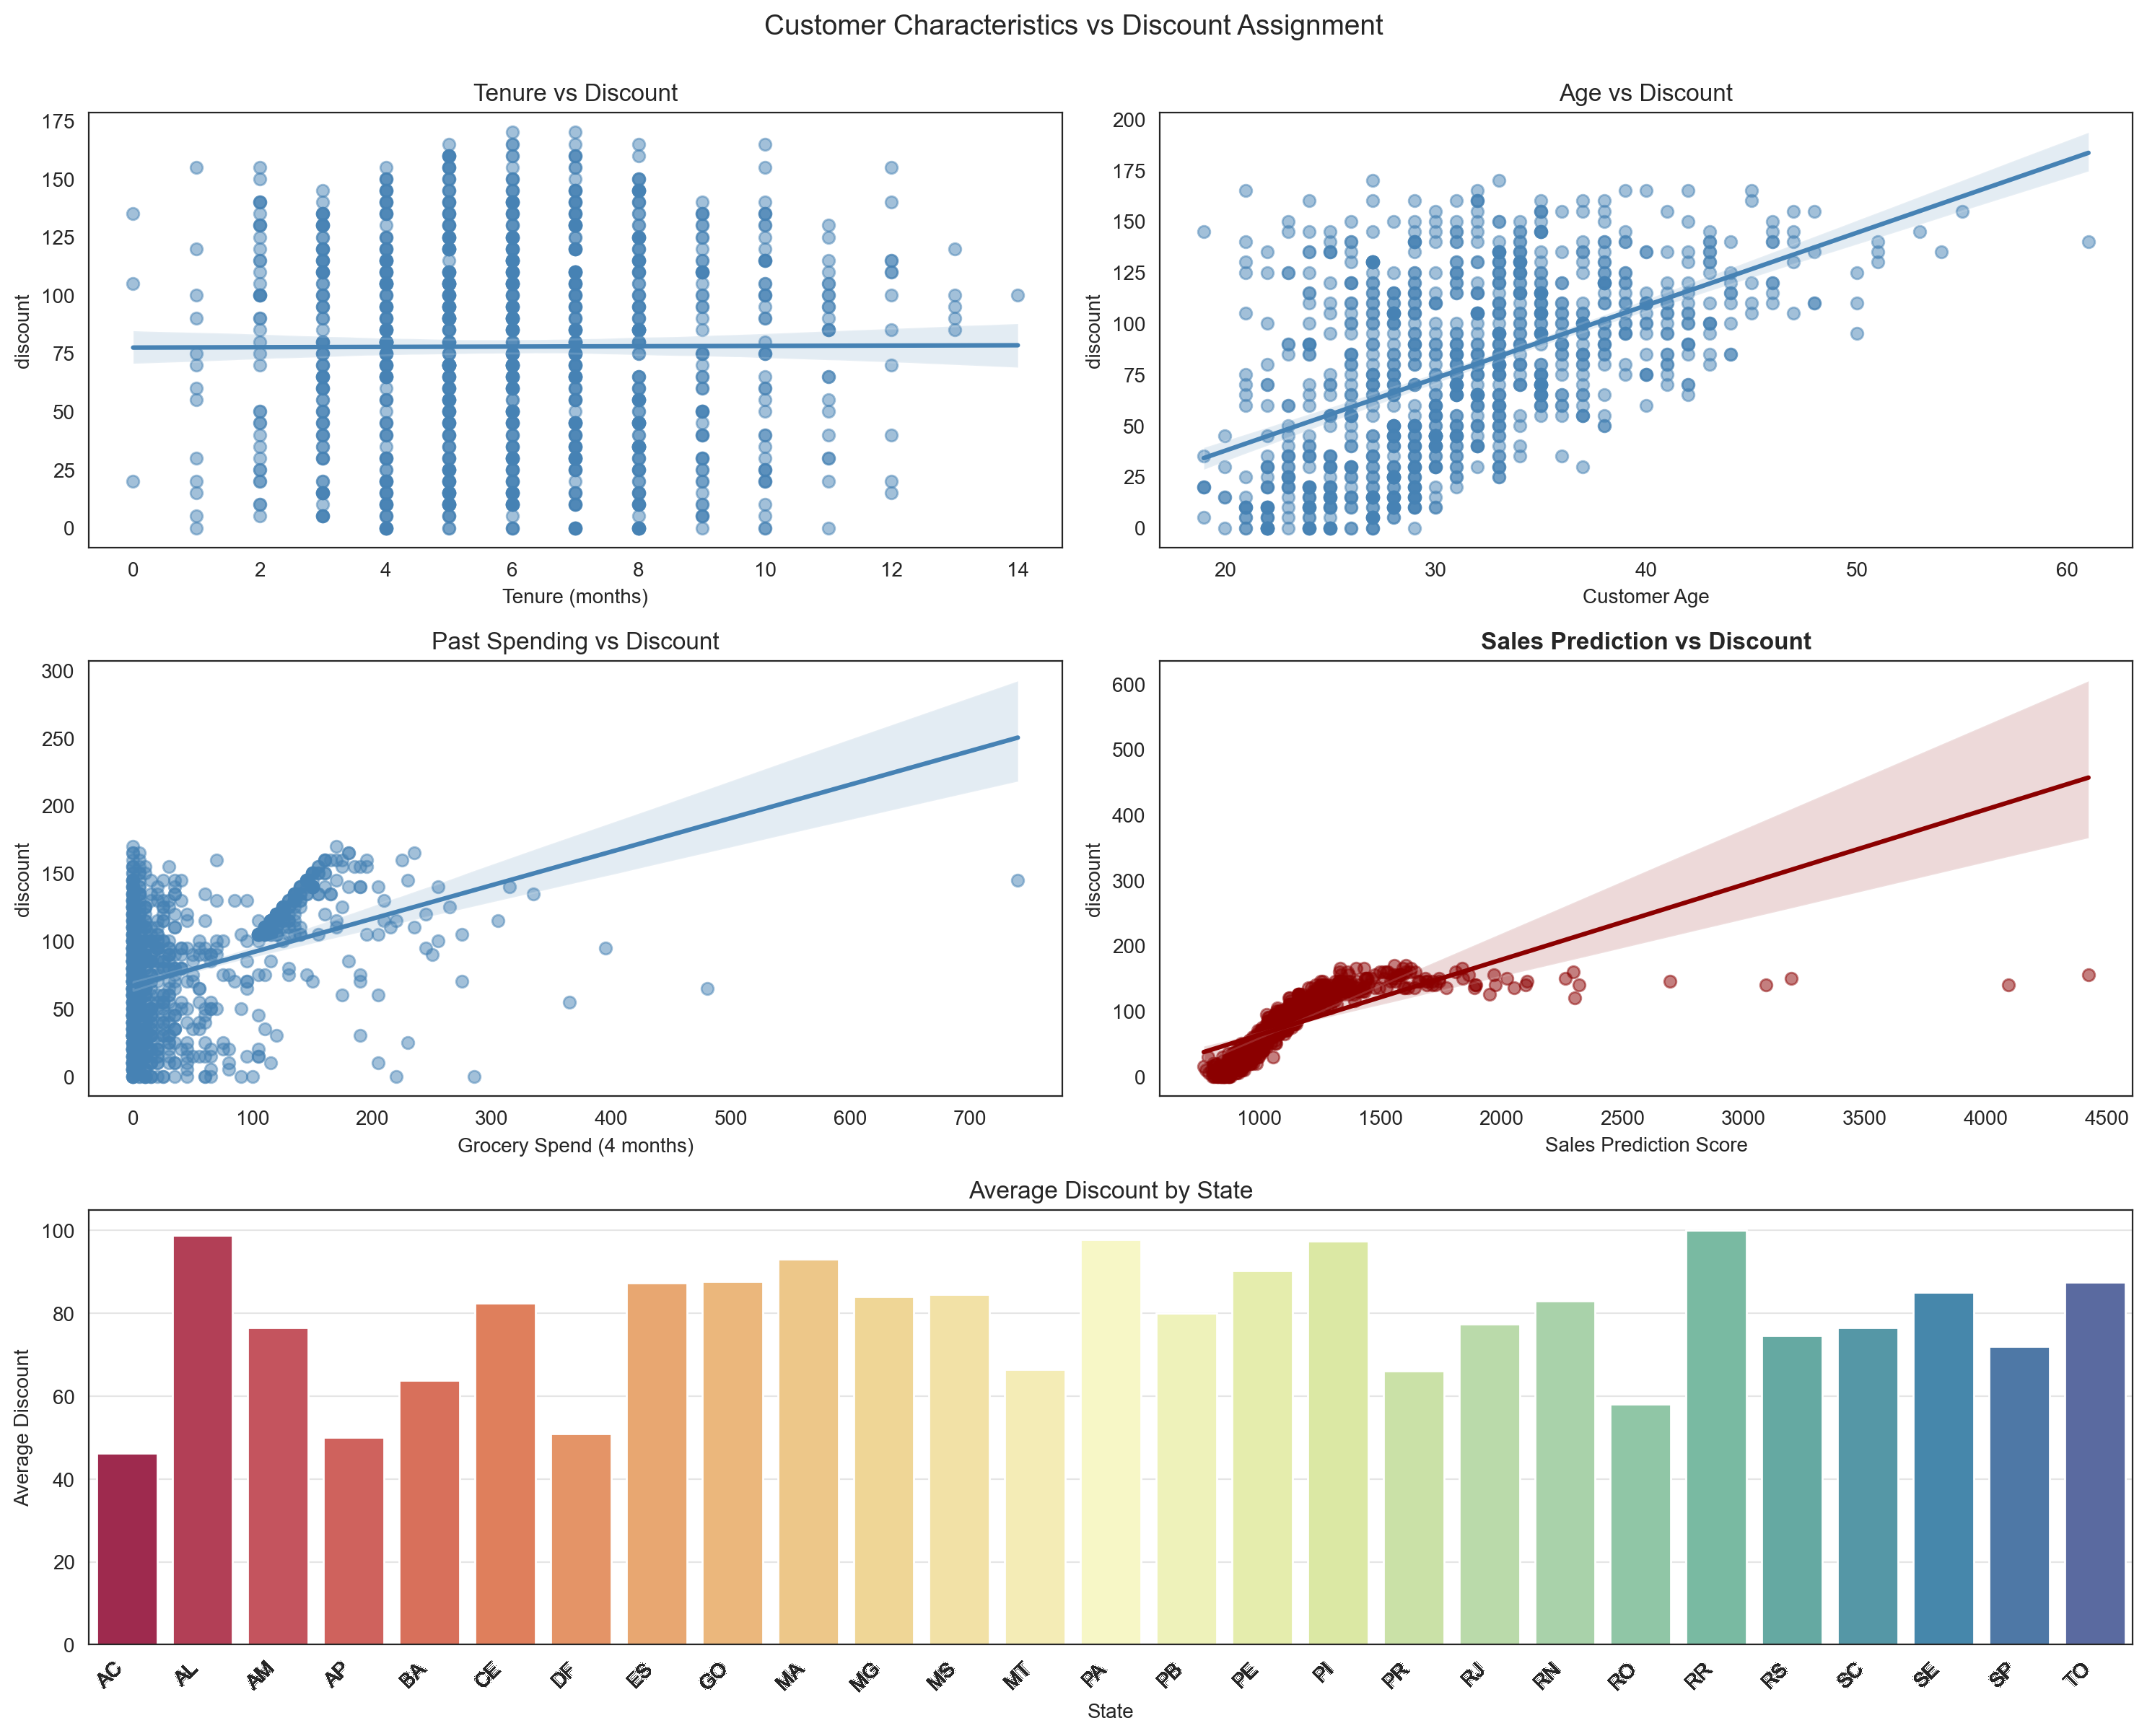

In [50]:
# Examining customer characteristics across discount levels
fig = plt.figure(figsize=(15, 12))

# Sample data once for consistency
np.random.seed(123)
sample_data = dataset.sample(1000)

# Create a 3x2 grid, but the last row will be one large plot
# First row
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))

# Second row  
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))

# Third row - spans both columns
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

# Tenure vs Discount
sns.regplot(data=sample_data, x="tenure", y="discount", 
            scatter_kws={"alpha":0.5}, ax=ax1, color='steelblue')
ax1.set_title('Tenure vs Discount')
ax1.set_xlabel('Tenure (months)')

# Age vs Discount  
sns.regplot(data=sample_data, x="age", y="discount", 
            scatter_kws={"alpha":0.5}, ax=ax2, color='steelblue')
ax2.set_title('Age vs Discount')
ax2.set_xlabel('Customer Age')

# Past spending vs Discount
sns.regplot(data=sample_data, x="spend_4m_groceries", y="discount", 
            scatter_kws={"alpha":0.5}, ax=ax3, color='steelblue')
ax3.set_title('Past Spending vs Discount')
ax3.set_xlabel('Grocery Spend (4 months)')

# Sales prediction vs Discount - THE KEY RELATIONSHIP
sns.regplot(data=sample_data, x="sales_prediction", y="discount", 
            scatter_kws={"alpha":0.5}, ax=ax4, color='darkred')
ax4.set_title('Sales Prediction vs Discount', fontweight='bold')
ax4.set_xlabel('Sales Prediction Score')

# State differences - all states using seaborn barplot
sns.barplot(data=sample_data.sort_values("cust_state"), x="cust_state", y="discount", 
            hue='cust_state', ax=ax5, legend=False, errorbar=None, palette='Spectral')
ax5.set_title('Average Discount by State')
ax5.set_xlabel('State')
ax5.set_ylabel('Average Discount')
ax5.set_xticks(dataset.cust_state)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
ax5.grid(axis='y', alpha=0.5) 

plt.suptitle('Customer Characteristics vs Discount Assignment', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

`Sales prediction`shows a notably stronger relationship with discount assignment compared to other customer features. The data suggests the company uses this ML model score as a primary factor in determining discount levels, with customers having higher predicted sales receiving larger discounts. This assignment mechanism introduces a classic confounding problem:


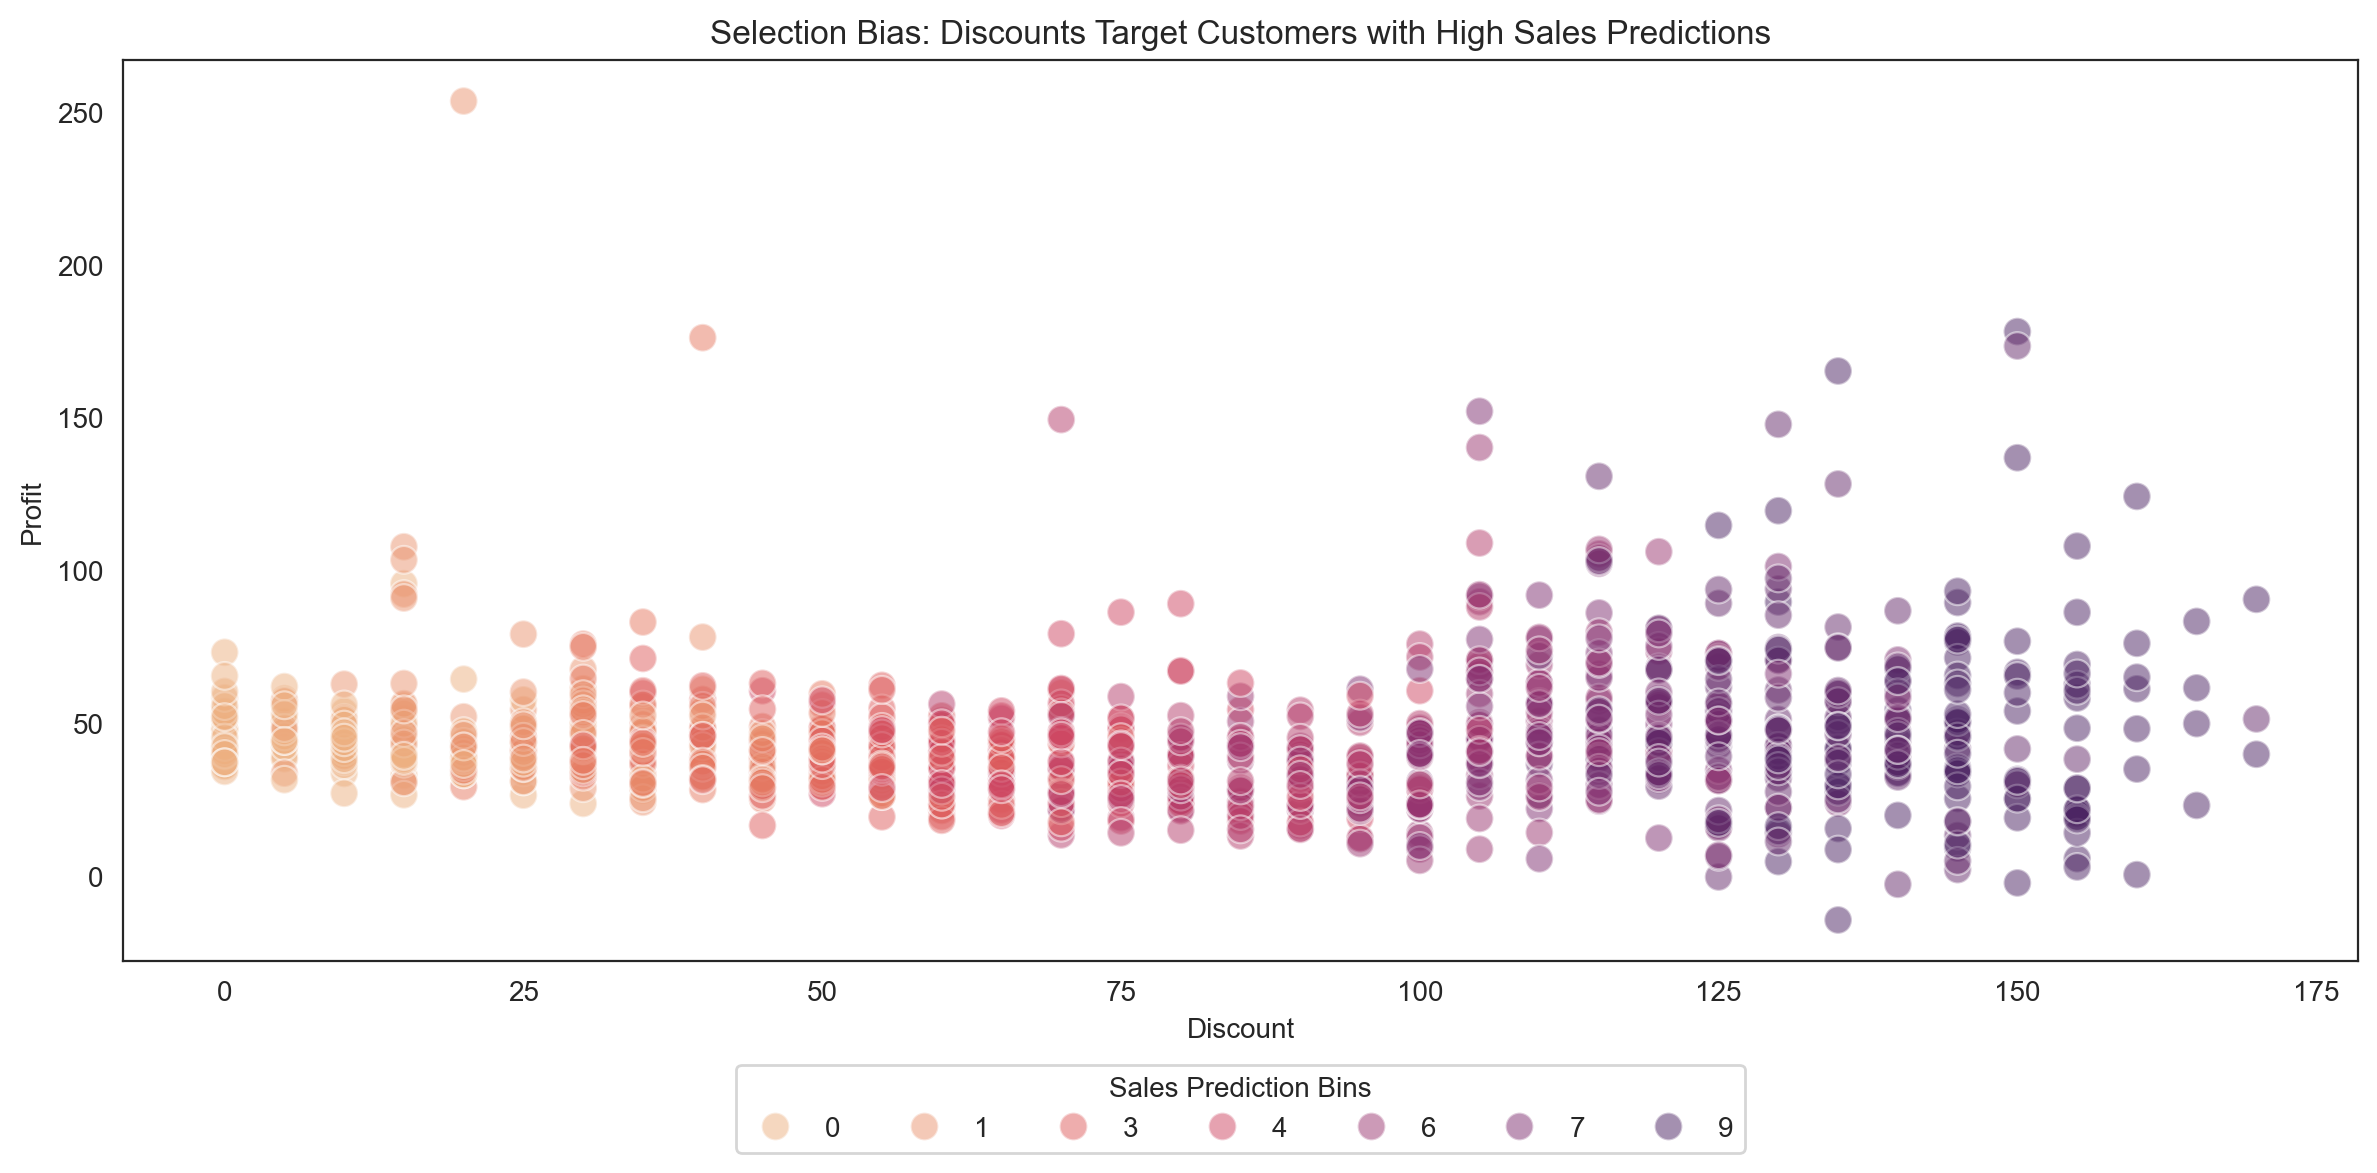

In [54]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=dataset.sample(1000), x="discount", y="profit", 
                hue="sales_prediction_bins", palette='flare', markers='o', alpha=0.5, s=100)

# Move legend to below center, horizontal orientation
plt.legend(title='Sales Prediction Bins', 
           bbox_to_anchor=(0.5, -0.1), 
           loc='upper center', 
           ncol=10,  # Adjust this based on how many bins you have
           frameon=True)

plt.title('Selection Bias: Discounts Target Customers with High Sales Predictions')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.tight_layout()
plt.show()

Customers with higher sales predictions consistently receive more discounts AND generate more profit. But these are customers the model predicted would spend more anyway—would they have been profitable even without the discount? The positive correlation between discount and profit may simply reflect that the company gives discounts to customers with high predicted sales—those the ML model identified as likely big spenders regardless of discounts.

## Addressing the Confounding Bias
### The Selection Problem
The analysis reveals that customers with higher sales predictions systematically receive larger discounts. This creates a selection bias: customers getting high discounts would likely have generated more profit even without any discount. In causal inference terms:
$$
E[Profit_0|Discount=High] > E[Profit_0|Discount=Low]
$$
High-discount customers (those with high sales predictions) would outspend low-discount customers even in a counterfactual world with no discounts. This means the positive correlation between discount and profit is misleading—it's driven by customer selection, not treatment effect.


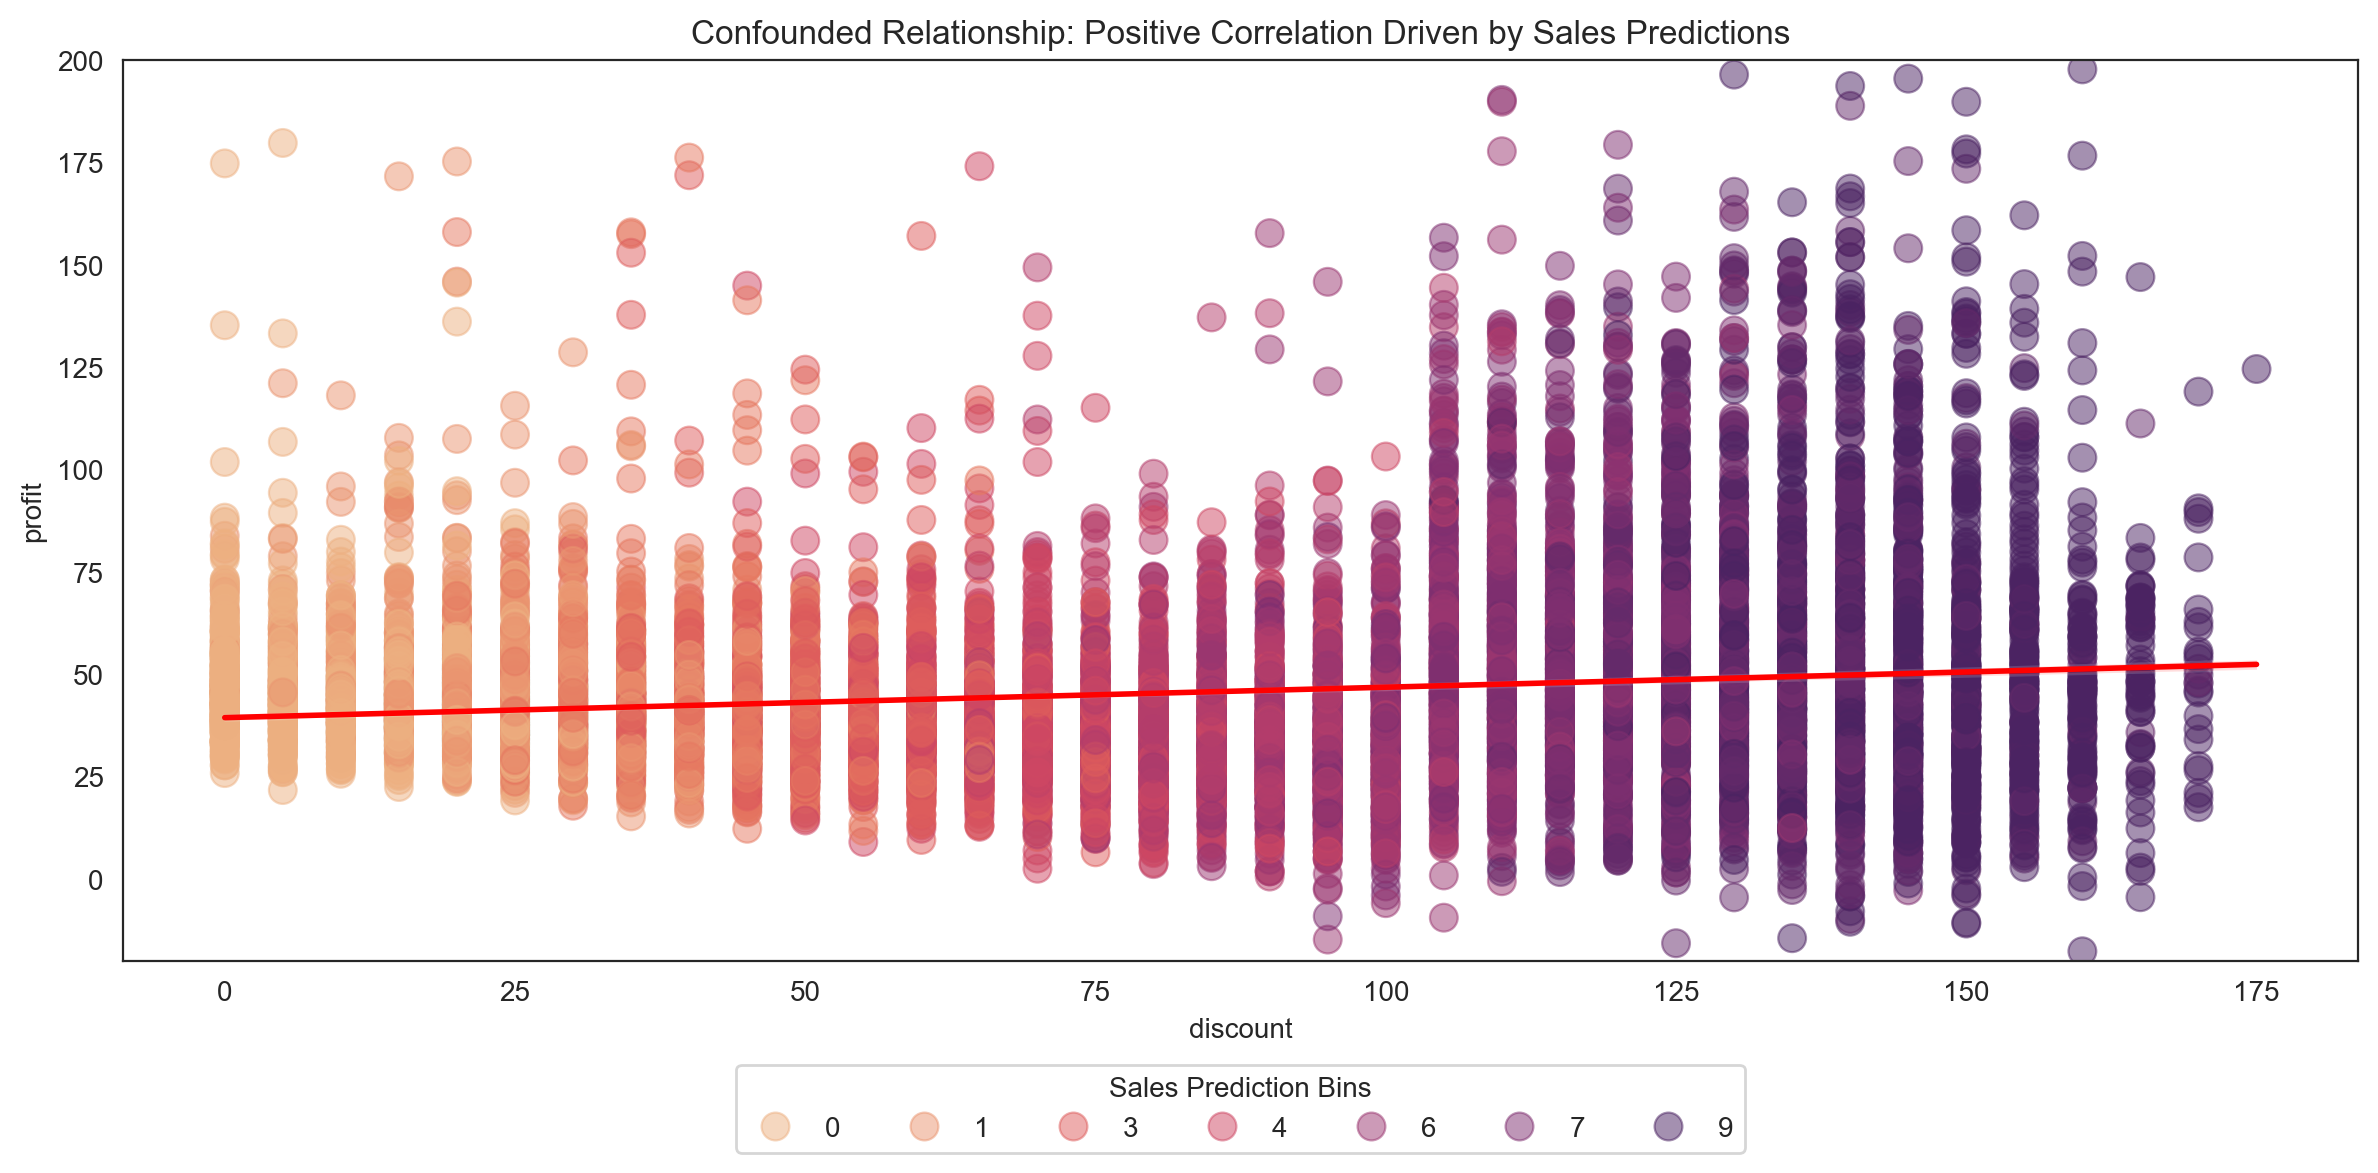

In [56]:
# Visualizing the confounded relationship
plt.figure(figsize=(12, 6))
sns.scatterplot(data=dataset, x="discount", y="profit", hue="sales_prediction_bins", palette='flare',edgecolor=None, markers='o',
                alpha=0.5, s= 100)
sns.regplot(data=dataset, x="discount", y="profit", scatter=False, color='red', line_kws={'linewidth':2})
plt.title("Confounded Relationship: Positive Correlation Driven by Sales Predictions")
plt.legend(title='Sales Prediction Bins', 
           bbox_to_anchor=(0.5, -0.1), 
           loc='upper center', 
           ncol=10,  # Adjust this based on how many bins you have
           frameon=True)

plt.ylim(-20, 200)
plt.tight_layout()
plt.show()

### Understanding Confounding
Sales prediction acts as a confounder—it influences both discount assignment and profit outcomes. We can visualize this causal structure:

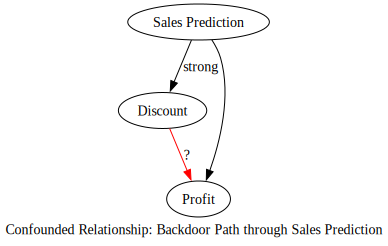

In [9]:
import graphviz as gr

# The confounded causal graph
g = gr.Digraph()
g.edge("Sales Prediction", "Discount", label="strong")
g.edge("Sales Prediction", "Profit")
g.edge("Discount", "Profit", color="red", label="?")

g.attr(label="Confounded Relationship: Backdoor Path through Sales Prediction")
g


### Creating a Quasi-Experiment with Regression

To isolate the causal effect, we need to compare "like with like"—customers with similar sales predictions but different discount levels. The Frisch-Waugh-Lovell theorem shows us exactly what regression does: it creates residualized versions of treatment and outcome that are orthogonal to confounders.

#### Step 1: Remove confounder's influence on treatment

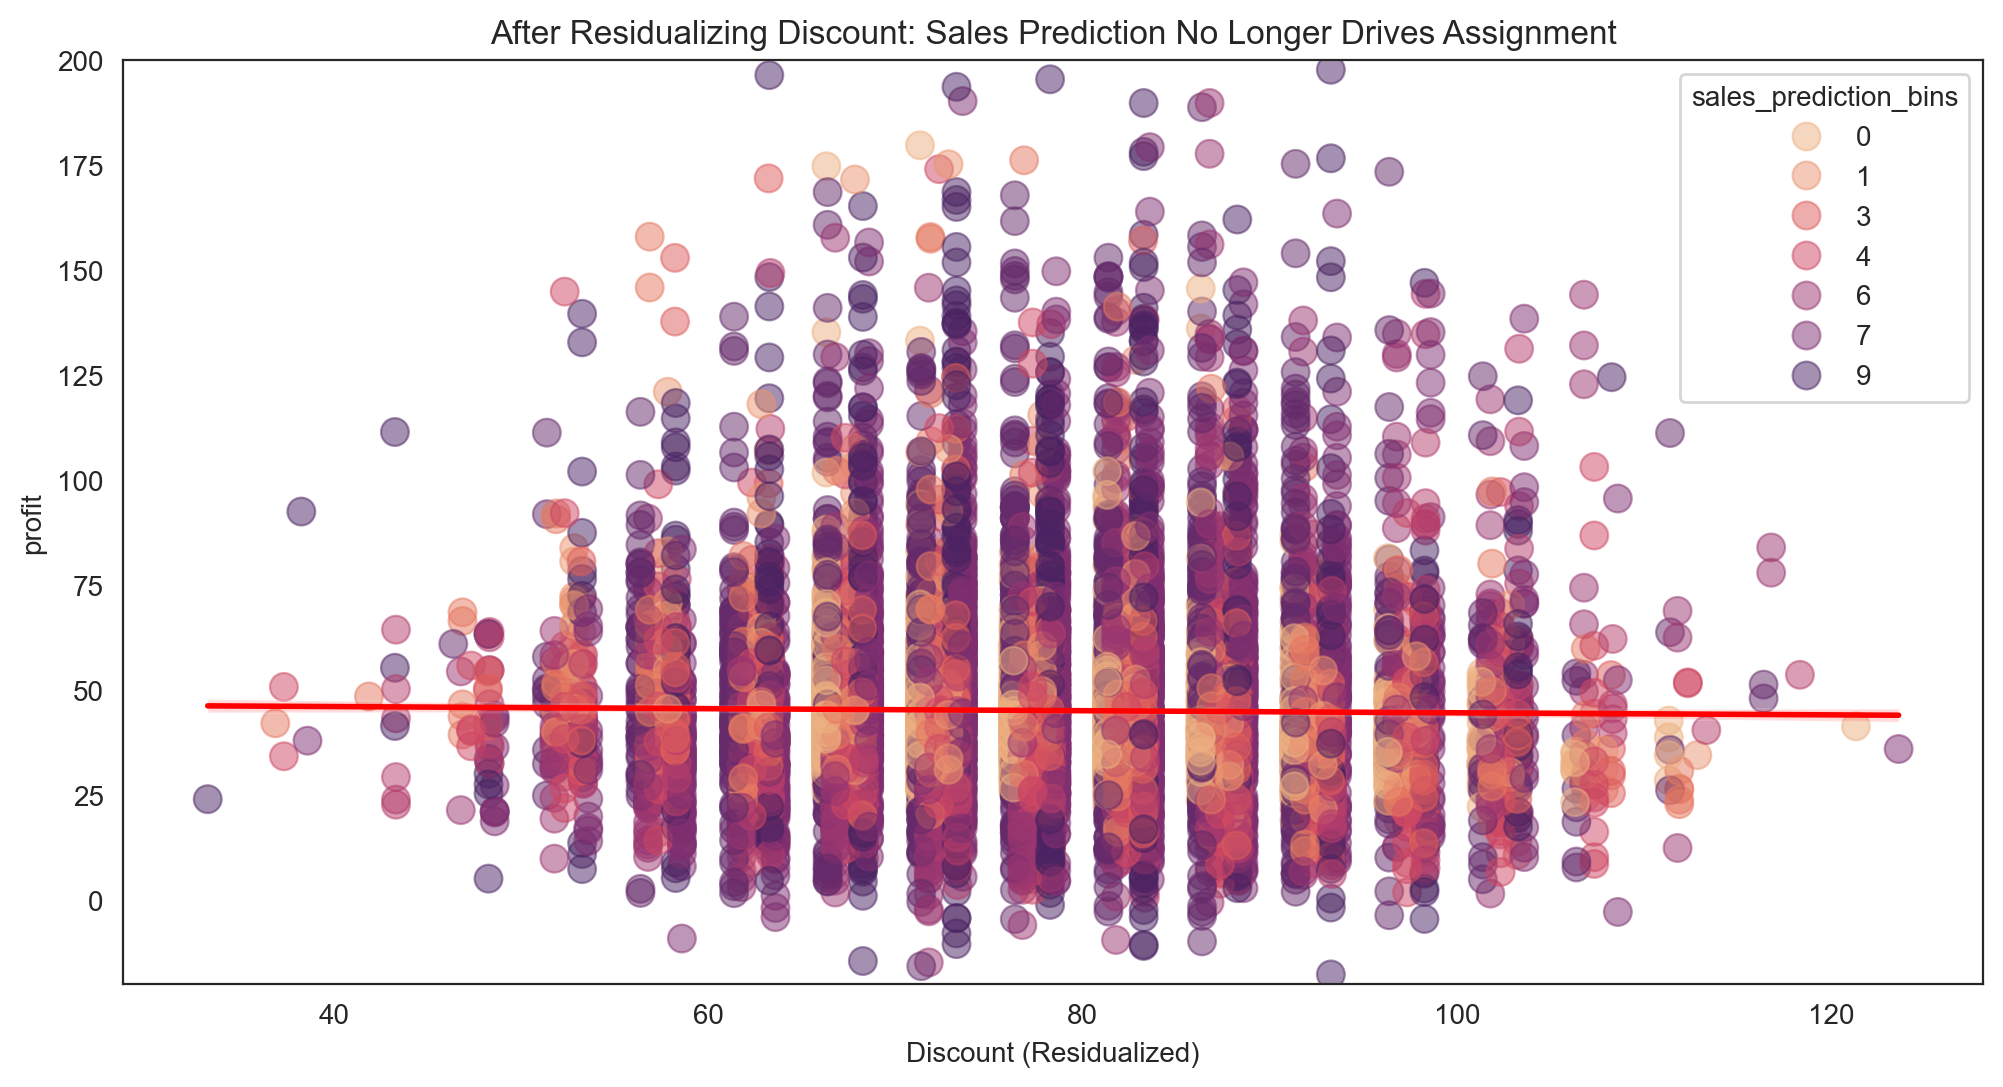

In [52]:
# Residualize discount with respect to sales prediction
model_discount = smf.ols("discount ~ C(sales_prediction_bins)", data=dataset).fit()
dataset['discount_residual'] = model_discount.resid + dataset["discount"].mean()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=dataset, x="discount_residual", y="profit", hue="sales_prediction_bins", palette='flare', edgecolor = None,
                 alpha = 0.5, s = 100)
sns.regplot(data=dataset, x="discount_residual", y="profit", scatter=False, color='red', line_kws={'linewidth':2})
plt.title('After Residualizing Discount: Sales Prediction No Longer Drives Assignment')
plt.xlabel('Discount (Residualized)')
plt.ylim(-20, 200)
plt.show()

Notice the dramatic change: the relationship turns negative! By residualizing, we've created a scenario where discount variation is "as-if randomized" within sales prediction bins!


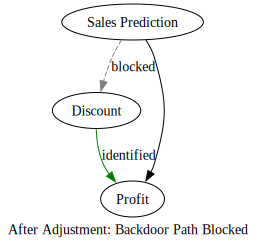

In [11]:
# The adjusted causal graph (conceptually)
g2 = gr.Digraph()
g2.edge("Sales Prediction", "Discount", style="dashed", color="gray", label="blocked")
g2.edge("Sales Prediction", "Profit")
g2.edge("Discount", "Profit", color="green", label="identified")

g2.attr(label="After Adjustment: Backdoor Path Blocked")
g2


#### Step 2: Remove confounder's influence on outcome

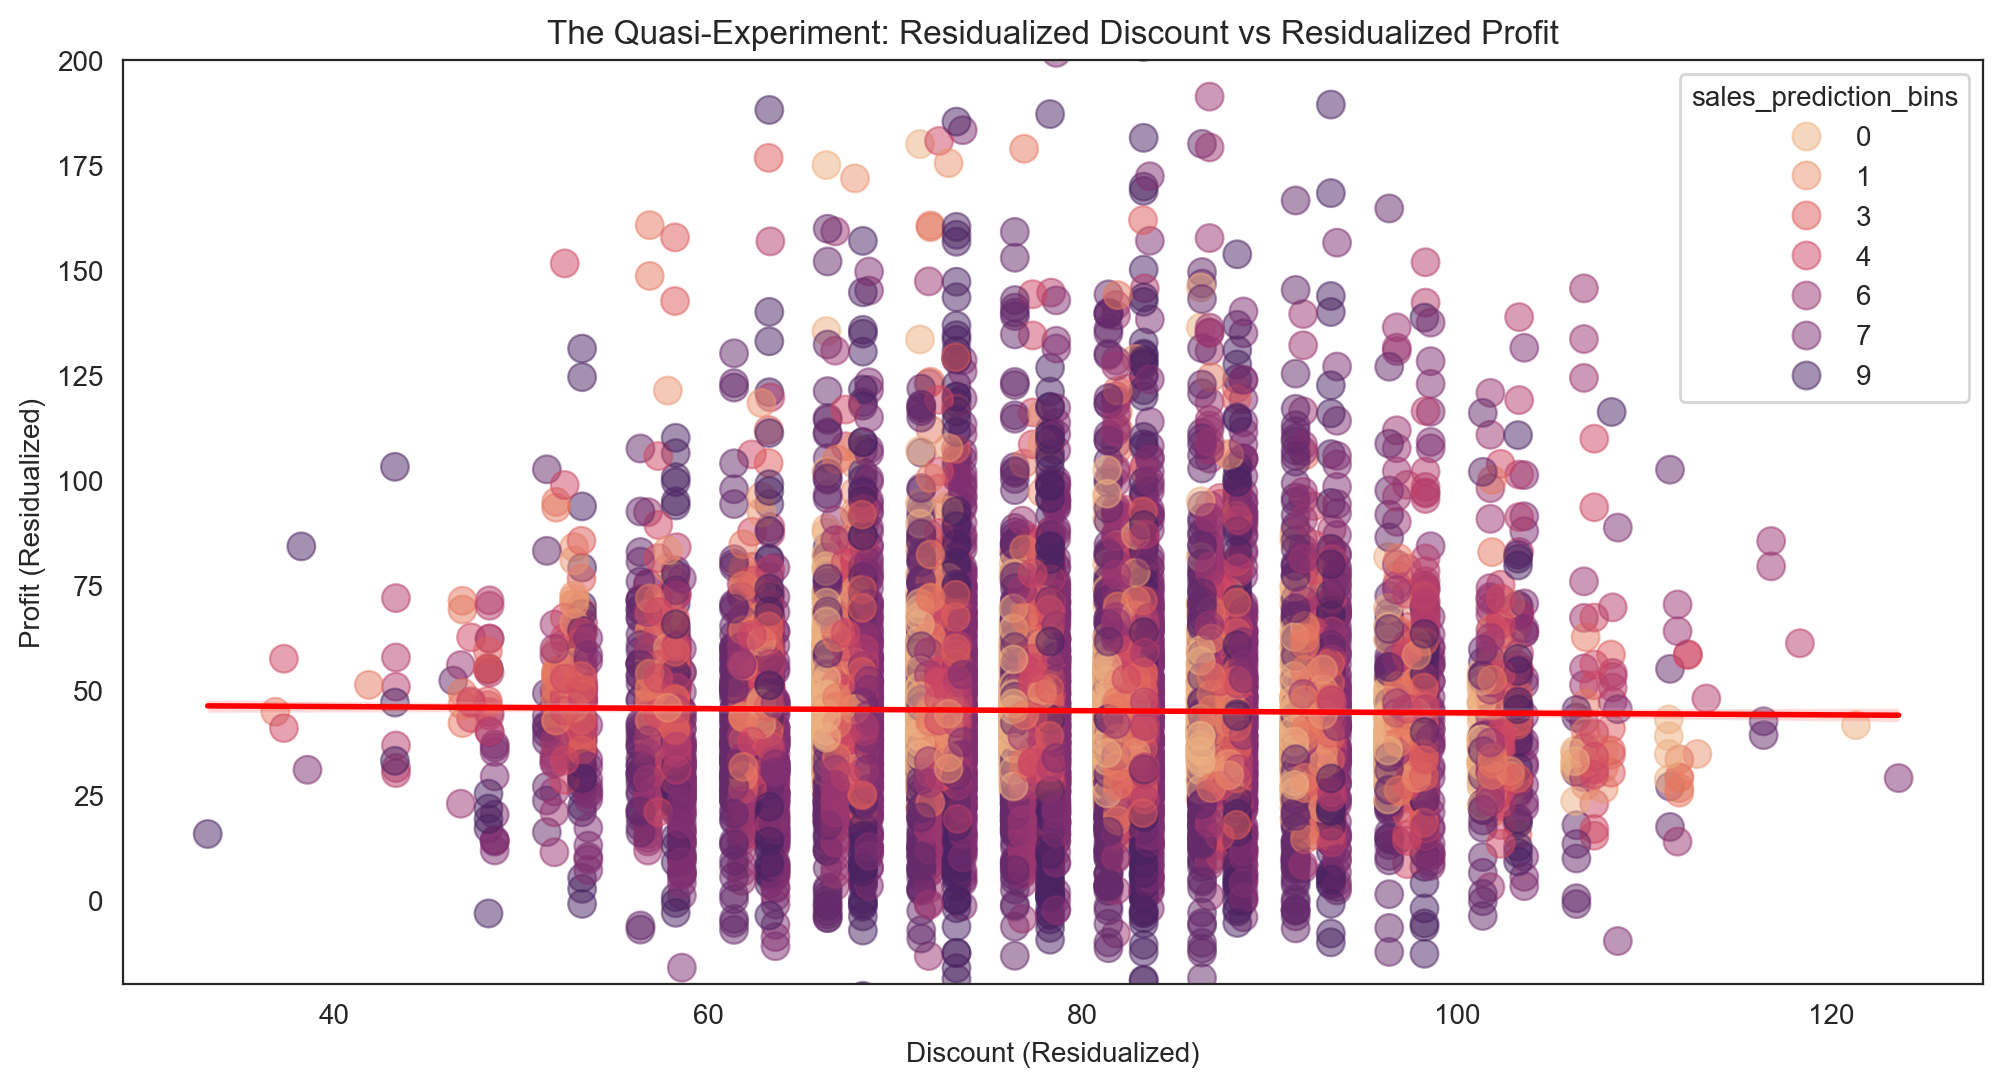

In [53]:
# Residualize profit with respect to sales prediction
model_profit = smf.ols("profit ~ C(sales_prediction_bins)", data=dataset).fit()
dataset['profit_residual'] = model_profit.resid + dataset["profit"].mean()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=dataset, x="discount_residual", y="profit_residual", hue="sales_prediction_bins", palette='flare', edgecolor =None,
                markers='o',alpha=0.5, s= 100) 
sns.regplot(data=dataset, x="discount_residual", y="profit_residual", scatter=False, color='red', line_kws={'linewidth':2})
plt.title('The Quasi-Experiment: Residualized Discount vs Residualized Profit')
plt.xlabel('Discount (Residualized)')
plt.ylabel('Profit (Residualized)')
plt.ylim(-20, 200)
plt.show()

This is our quasi-experimental result: within groups of similar sales predictions, more discount leads to __less__ profit.

The two-step residualization above is mathematically equivalent to running a single multiple regression:

In [69]:
# Multiple regression - controlling only for sales prediction
model_basic = smf.ols("profit ~ discount + C(sales_prediction_bins)", data=dataset).fit()

print("Basic Model Results:")
print(f"Discount coefficient: {model_basic.params['discount']:.4f}")
print(f"Standard error: {model_basic.bse['discount']:.4f}")
print(f"P-value: {model_basic.pvalues['discount']:.4f}")
print(f"95% CI: [{model_basic.conf_int().loc['discount', 0]:.4f}, {model_basic.conf_int().loc['discount', 1]:.4f}]")

Basic Model Results:
Discount coefficient: -0.0247
Standard error: 0.0169
P-value: 0.1433
95% CI: [-0.0578, 0.0084]


__Interpretation__: Holding sales predictions constant, each additional unit of discount __decreases__ profit by approximately 0.0247. This is our causal estimate—the effect of discounts after removing selection bias.

#### Improving Precision with Additional Controls

While sales prediction is the primary confounder (it determines assignment), other variables like age and tenure also predict profit. Adding them as controls reduces residual variance and improves precision:


In [15]:
# Enhanced model with additional controls
model_control = smf.ols("profit ~ discount + C(sales_prediction_bins) + age + tenure", data=dataset).fit()

# Compare results
comparison = pd.DataFrame({
    'Basic Model': [
        model_basic.params['discount'],
        model_basic.bse['discount'],
        model_basic.pvalues['discount'],
        model_basic.conf_int().loc['discount', 0],
        model_basic.conf_int().loc['discount', 1]
    ],
    'Model With Controls': [
        model_control.params['discount'],
        model_control.bse['discount'],
        model_control.pvalues['discount'],
        model_control.conf_int().loc['discount', 0],
        model_control.conf_int().loc['discount', 1]
    ]
}, index=['Coefficient', 'Std Error', 'P-value', '95% CI Lower', '95% CI Upper'])

print("\nModel Comparison:")
print(comparison)


Model Comparison:
              Basic Model  Model With Controls
Coefficient     -0.024708            -0.053187
Std Error        0.016881             0.015649
P-value          0.143296             0.000679
95% CI Lower    -0.057797            -0.083862
95% CI Upper     0.008380            -0.022513


After adjusting for the confounding effect of sales predictions, discounts appear to reduce profits. The initially positive correlation was entirely driven by selection bias—the company was giving more discounts to customers who would have spent more anyway. This suggests the current discount strategy is destroying value rather than creating it.


##  Can we do better?

We've established that discounts reduce profits on average. But "on average" might hide important variation—some customers might actually respond positively to discounts while others respond negatively. If we could identify these segments, we could transform a money-losing strategy into a profitable one by targeting only responsive customers. This will be the topic of a future post.
